In [1]:
import math as m
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

from pymatgen.util import coord
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.sites import Site
from ase.visualize.plot import plot_atoms
from copy import copy, deepcopy

In [2]:
def vacanciesS_S(x):
    return 2.693 - 1/(15 + 2 * x)

def vacanciesS_SoneLayer(x):
    return 2.669 + m.cos(1 - x) /(15 + 2 * x)

def vacanciesS_SdifLayer(x):
    return 2.693 + m.cos(5 - x) / ((2**x) + 1 + x)

def vacanciesS_Mo(x):
    return 4.895 + (m.cos(0.5) * m.cos(8 - 2 * x) - 1)* x**2 * m.exp(-x)

In [3]:
def printStructure(d):
    s0 = d.initial_structure
    d0 = list(d.defect_representation)
    ase_atoms = AseAtomsAdaptor.get_atoms(s0)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)
    ax.set_title(f'{d0}')

In [4]:
def distanceCalc(pos, defect, emptyStructure):
    x = (emptyStructure.initial_structure[pos].frac_coords[0] - emptyStructure.initial_structure[defect].frac_coords[0]) ** 2
    y = (emptyStructure.initial_structure[pos].frac_coords[1] - emptyStructure.initial_structure[defect].frac_coords[1]) ** 2
    z = (emptyStructure.initial_structure[pos].frac_coords[2] - emptyStructure.initial_structure[defect].frac_coords[2]) ** 2
    distance = m.sqrt(x + y + z)
    return distance


def addDefect(energy, current_e, positions, defType, emptySructure):
    chosen = -1
    chosen_e = 0
    if not len(positions):
        if defType == "l1S":
            chosen = np.random.randint(64, 127)
        elif defType == "l2S":
            chosen = np.random.randint(128, 191)
        elif defType == "Mo":
            chosen = np.random.randint(0, 63)
        positions.append(chosen)
        return 0

    if defType == "l1S":
        for i in range(64, 128):
            if i not in positions:
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    new_e = 0
                    if defect > 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                        chosen = i
                        chosen_e = new_e

    elif defType == "l2S":
        for i in range(128, 192):
            if i not in positions:
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    new_e = 0
                    if defect > 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                        chosen = i
                        chosen_e = new_e

    elif defType == "Mo":
        for i in range(0, 6):
            if i not in positions:
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    new_e = 0
                    if defect > 63:
                        new_e += vacanciesS_Mo(distance)
                    if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                        chosen = i
                        chosen_e = new_e
    positions.append(chosen)
    return current_e + chosen_e

In [5]:
def twoDefects(energy, emptySructure, elements):
    defects = []
    for x in elements:
        for y in elements:
            if [x, y].count('Mo') <= 1:
                positions = []
                current_e = 0
                current_e = addDefect(energy, current_e, positions, x, emptySructure)
                current_e = addDefect(energy, current_e, positions, y, emptySructure)
                defects.append([current_e, positions])
    return defects


def threeDefects(energy, emptySructure, elements):
    defects = []
    for x in elements:
        for y in elements:
            for z in elements:
                if [x, y, z].count('Mo') <= 1:
                    positions = []
                    current_e = 0
                    current_e = addDefect(energy, current_e, positions, x, emptySructure)
                    current_e = addDefect(energy, current_e, positions, y, emptySructure)
                    current_e = addDefect(energy, current_e, positions, z, emptySructure)
                    defects.append([current_e, positions])
    return defects

In [6]:
def applyDefects(current_e, defects):
    
    emptySructure = pd.read_pickle('emptydata.pkl')
    emptySructure = emptySructure.iloc[0]
    emptySructure.defect_representation.clear()
    
    print("Energy:", current_e, "Defects:", defects)
    for i in range(len(defects)):
        if defects[i] < 64:
            emptySructure.initial_structure.replace(defects[i], Element('W'))
        else:
            emptySructure.initial_structure.replace(defects[i], Element('Li'))
        emptySructure.defect_representation.append(emptySructure.initial_structure[defects[i]].species,
                                                   emptySructure.initial_structure[defects[i]].frac_coords)
    return emptySructure

Expected formation energy: 5
Number of defects: 2
How many examples: 4
Energy: 4.883190366199462 Defects: [29, 94]


C:\Users\lebed\AppData\Local\Temp\ipykernel_13512\2578690950.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


Energy: 4.883190366013288 Defects: [15, 144]


C:\Users\lebed\AppData\Local\Temp\ipykernel_13512\2578690950.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


Energy: 4.869222610627067 Defects: [74, 2]


C:\Users\lebed\AppData\Local\Temp\ipykernel_13512\2578690950.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


Energy: 4.848080412299749 Defects: [154, 5]


C:\Users\lebed\AppData\Local\Temp\ipykernel_13512\2578690950.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


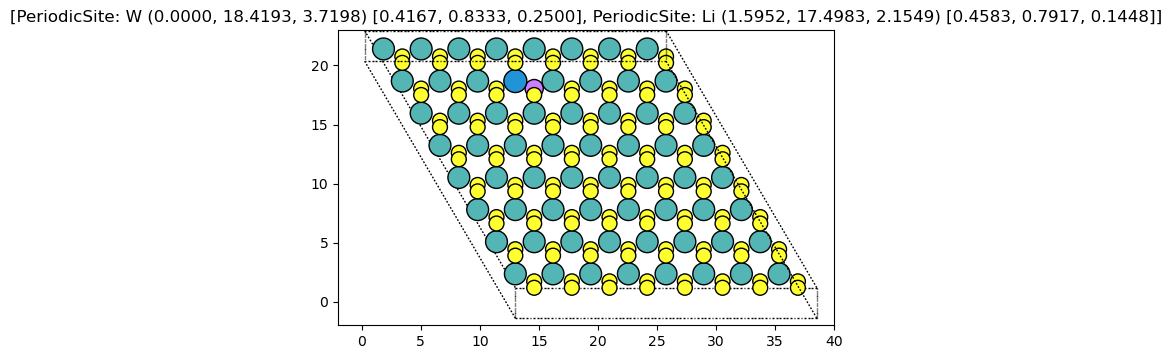

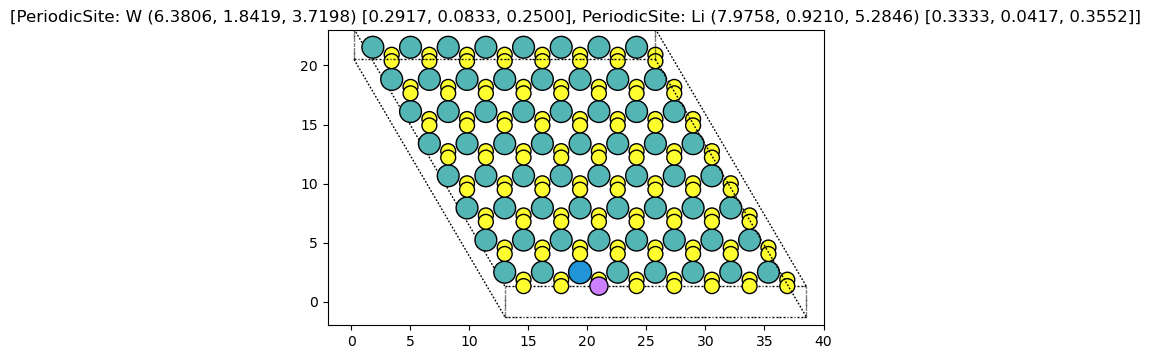

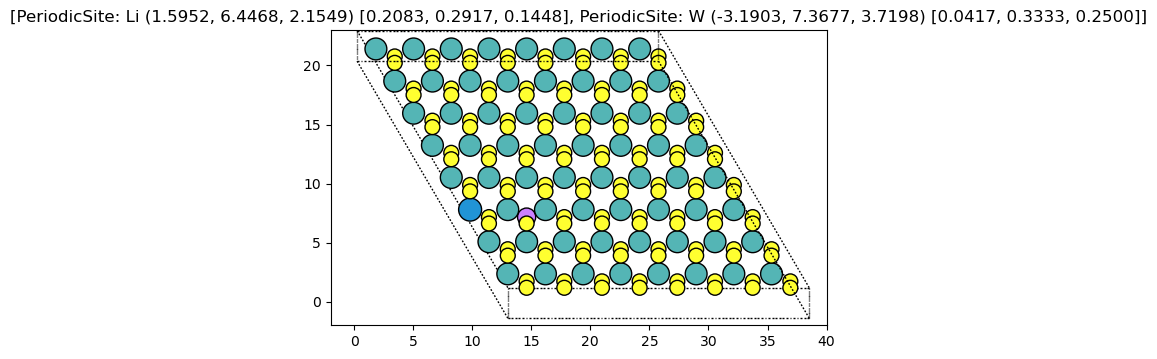

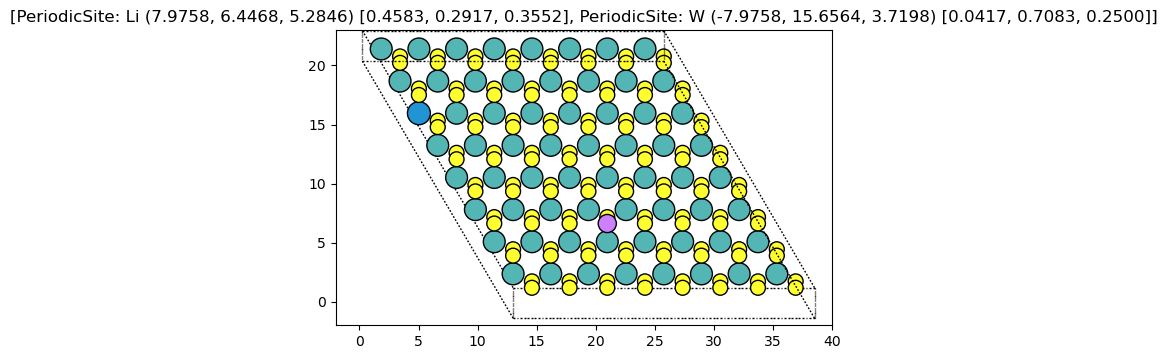

In [7]:
dataBegin = pd.read_pickle('emptydata.pkl')
dataBegin = dataBegin.iloc[0]
dataBegin.defect_representation.clear()

elements = ['l1S','l2S','Mo'] #l1S, l2S - S vacancies from lower and higher lvls respectfuly

energy = float(input("Expected formation energy: "))
number_of_defects = int(input("Number of defects: "))
number_of_examples = int(input("How many examples: ")) #for 2 defects - < 9, for 3 - < 15
 
if number_of_defects == 2:
    defects = twoDefects(energy, dataBegin, elements)
elif number_of_defects == 3:
    defects = threeDefects(energy, dataBegin, elements)

sortedDefects = sorted(defects, key=lambda x: (x[0] - energy)**2)

allData = pd.DataFrame()
for i in range(number_of_examples):
    newData = applyDefects(sortedDefects[i][0], sortedDefects[i][1])
    printStructure(newData)
    allData = allData.append(newData)

In [8]:
allData

,descriptor_id,energy,energy_per_atom,fermi_level,homo,lumo,defect_representation,formation_energy,initial_structure,formation_energy_per_site,band_gap
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,[[1.27612635e-07 1.84192962e+01 3.71975100e+00...,0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[6.38063153 1.84192955 3.719751 ] W, [7.9757...",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[1.59515772 6.44675377 2.15486663] Li, [-3.19...",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[7.97578912 6.44675377 5.28463537] Li, [-7.97...",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
